In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from fbprophet import Prophet
#import prophet

In [53]:
#trainデータ
df=pd.read_csv("rohini_1016_6hours.csv").iloc[:,1:]
#検証用データ
test=pd.read_csv("rohini_1113_6hours.csv").iloc[:,1:]

In [54]:
df.head()

,local_time,rohini
0,2019-07-19 12:00:00,58.500000
1,2019-07-20 00:00:00,64.333333
2,2019-07-20 12:00:00,49.666667
3,2019-07-21 00:00:00,42.583333
4,2019-07-21 12:00:00,45.000000


In [55]:
df.dtypes

local_time     object
rohini        float64
dtype: object

In [56]:
test.head()

,local_time,rohini
0,2019-10-01 12:00:00,32.500000
1,2019-10-02 00:00:00,39.100000
2,2019-10-02 12:00:00,39.000000
3,2019-10-03 00:00:00,64.090909
4,2019-10-03 12:00:00,94.272727


In [57]:
test.dtypes

local_time     object
rohini        float64
dtype: object

In [58]:
f=lambda x:datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

df["local_time"]=df["local_time"].apply(f)
test["local_time"]=test["local_time"].apply(f)

## 可視化

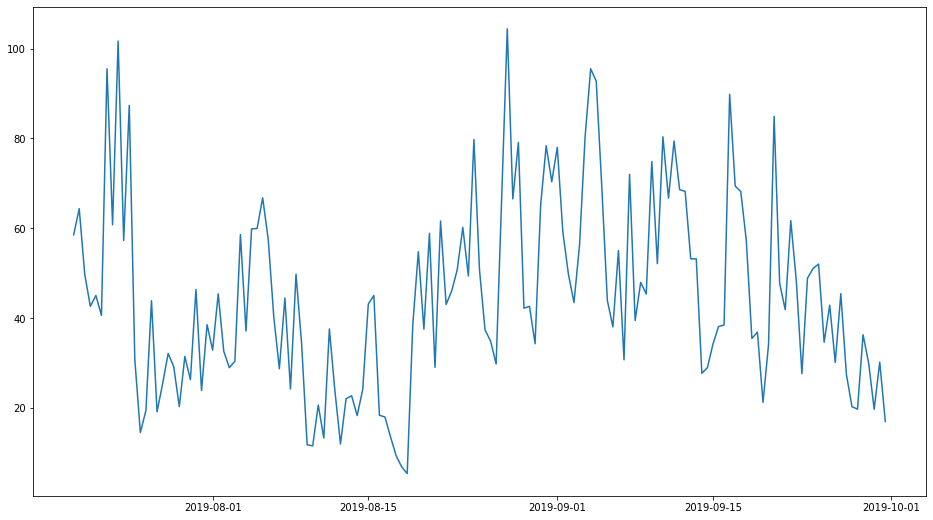

In [59]:
ts=df["rohini"].interpolate('linear')
ts.index=df["local_time"]

plt.figure(figsize=(16,9))
plt.plot(ts)

# 時系列モデルによる予測

In [60]:
df_prophet = pd.DataFrame()
df_prophet['ds'] = ts.index
df_prophet['y'] = ts.values

In [61]:
df_prophet

,ds,y
0,2019-07-19 12:00:00,58.500000
1,2019-07-20 00:00:00,64.333333
2,2019-07-20 12:00:00,49.666667
3,2019-07-21 00:00:00,42.583333
4,2019-07-21 12:00:00,45.000000
...,...,...
142,2019-09-28 12:00:00,36.250000
143,2019-09-29 00:00:00,30.000000
144,2019-09-29 12:00:00,19.666667
145,2019-09-30 00:00:00,30.166667


In [175]:
# Prophet用DataFrameを生成
df_prophet = pd.DataFrame()
df_prophet['ds'] = ts.index
df_prophet['y'] = ts.values
#df_prophet["cap"]=5.5
#df_prophet["floor"]=0.1

# Prophetモデルの構築
#m = Prophet(growth='linear',weekly_seasonality=True, daily_seasonality=True)
m = Prophet(growth='linear')
m.add_seasonality(name='monthly', period=30.5, fourier_order=10) #フーリエ係数大きいほど変動にフィット
m.add_seasonality(name='weekly', period=7, fourier_order=50) #フーリエ係数大きいほど変動にフィット
m.add_seasonality(name='daily', period=24, fourier_order=500) #フーリエ係数大きいほど変動にフィット

# 学習()
m.fit(df_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [176]:
# 将来7日間を予測
future = m.make_future_dataframe(periods=168, freq="H")
#future["cap"]=200
#future["floor"]=0
forecast= m.predict(future)


<Figure size 1152x648 with 0 Axes>

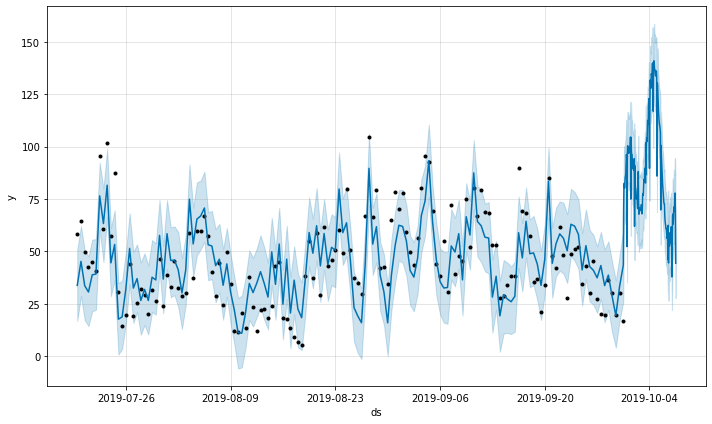

In [177]:
plt.figure(figsize=(16,9))
m.plot(forecast)
plt.show()

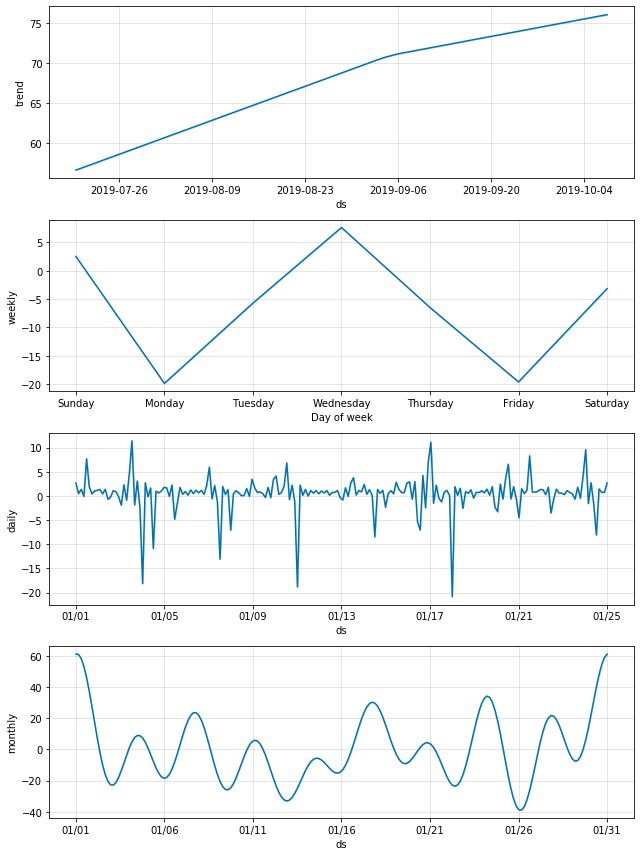

In [178]:
#forecast["yhat"]=np.exp(forecast["yhat"])

#m.plot(forecast_alipur)
fig = m.plot_components(forecast)

In [179]:
#trainデータでの精度

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# MAE
print('MSE : %.3f' % (mean_absolute_error(ts.values, forecast[:-168]["yhat"])))

# R^2
print('R^2  : %.3f' % (r2_score( ts.values ,forecast[:-168]["yhat"]))) 

MSE : 10.842
R^2  : 0.624


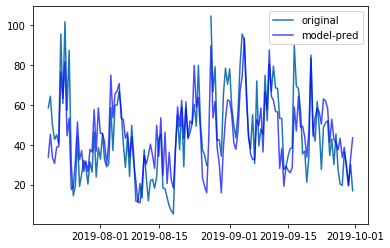

In [180]:
#plt.plot(df_pm25[["alipur", "utc"]][-72:], label="original")

plot_values = pd.Series(df["rohini"][-168:], dtype="float")
plot_values.index= pd.to_datetime(df["local_time"][-168:])

plot_values_pred = pd.Series(forecast[-168*2:-168]["yhat"], dtype="float")
plot_values_pred.index= pd.to_datetime(forecast[-168*2:-168]["ds"])



plt.plot(plot_values, label="original")
plt.plot(plot_values_pred , c="b", label="model-pred", alpha=0.7)
plt.legend(loc='best')

# テストデータで精度比較

In [181]:
test.head()

,local_time,rohini
0,2019-10-01 12:00:00,32.500000
1,2019-10-02 00:00:00,39.100000
2,2019-10-02 12:00:00,39.000000
3,2019-10-03 00:00:00,64.090909
4,2019-10-03 12:00:00,94.272727


In [182]:
forecast[-156:][["ds", "yhat"]]

,ds,yhat
159,2019-10-01 01:00:00,97.186775
160,2019-10-01 02:00:00,100.433182
161,2019-10-01 03:00:00,98.843675
162,2019-10-01 04:00:00,96.855987
163,2019-10-01 05:00:00,96.893379
...,...,...
310,2019-10-07 08:00:00,69.264912
311,2019-10-07 09:00:00,76.110607
312,2019-10-07 10:00:00,77.883622
313,2019-10-07 11:00:00,69.461984


In [183]:
#予測データの切り取り
tmp=forecast[-168:][["ds", "yhat"]]

In [184]:
value_list=[]
time_list=[]
row=0
for i in range(int(len(tmp)/12)):
    value=tmp.iloc[row : row+12,:].mean()
    value_list.append(value)
    time=tmp.iloc[row+11:row+12,:]["ds"].values[0]
    print(time)
    time_list.append(time)
    row=row+12
forecast_6hours=pd.DataFrame(value_list, time_list).reset_index()
forecast_6hours.columns=["ds", "yhat"]

2019-10-01T00:00:00.000000000
2019-10-01T12:00:00.000000000
2019-10-02T00:00:00.000000000
2019-10-02T12:00:00.000000000
2019-10-03T00:00:00.000000000
2019-10-03T12:00:00.000000000
2019-10-04T00:00:00.000000000
2019-10-04T12:00:00.000000000
2019-10-05T00:00:00.000000000
2019-10-05T12:00:00.000000000
2019-10-06T00:00:00.000000000
2019-10-06T12:00:00.000000000
2019-10-07T00:00:00.000000000
2019-10-07T12:00:00.000000000


In [185]:
forecast_6hours

,ds,yhat
0,2019-10-01 00:00:00,82.525370
1,2019-10-01 12:00:00,96.960923
2,2019-10-02 00:00:00,90.969430
3,2019-10-02 12:00:00,78.819064
4,2019-10-03 00:00:00,69.983127
5,2019-10-03 12:00:00,83.247699
6,2019-10-04 00:00:00,106.530126
7,2019-10-04 12:00:00,131.097136
8,2019-10-05 00:00:00,132.282553
9,2019-10-05 12:00:00,112.684862


In [186]:
test[:14]

,local_time,rohini
0,2019-10-01 12:00:00,32.500000
1,2019-10-02 00:00:00,39.100000
2,2019-10-02 12:00:00,39.000000
3,2019-10-03 00:00:00,64.090909
4,2019-10-03 12:00:00,94.272727
5,2019-10-04 00:00:00,60.083333
6,2019-10-04 12:00:00,47.250000
7,2019-10-05 00:00:00,47.416667
8,2019-10-05 12:00:00,51.000000
9,2019-10-06 00:00:00,39.400000


In [187]:
#trainデータでの精度

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# MAE
print('MAE : %.3f' % (mean_absolute_error(test[:14]["rohini"], forecast_6hours["yhat"])))

# R^2
print('R^2  : %.3f' % (r2_score(test[:14]["rohini"] ,forecast_6hours["yhat"])))

MAE : 41.281
R^2  : -7.818


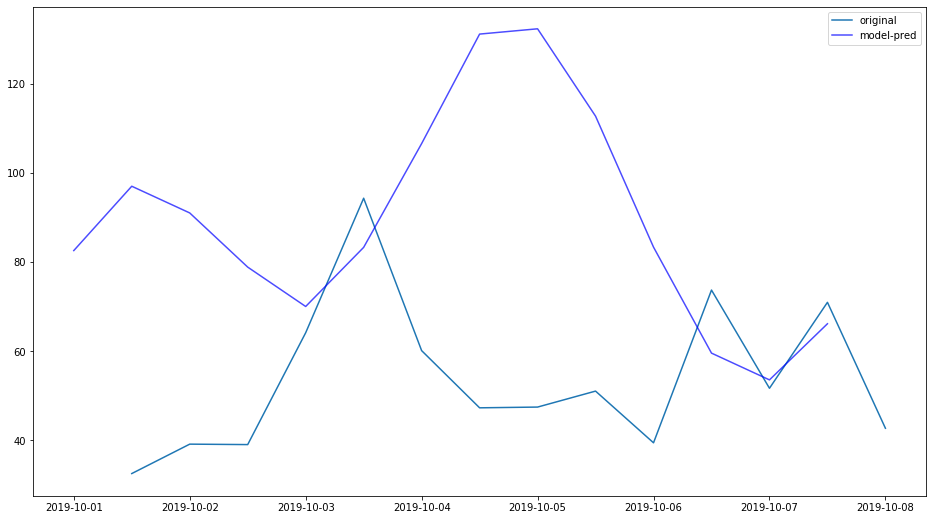

In [189]:
plot_values_test = pd.Series(test[:14]["rohini"], dtype="float")
plot_values_test.index= pd.to_datetime(test["local_time"][:14])

plot_values_pred6 = pd.Series(forecast_6hours["yhat"], dtype="float")
plot_values_pred6.index= pd.to_datetime(forecast_6hours["ds"])


plt.figure(figsize=(16,9))
plt.plot(plot_values_test, label="original")
plt.plot(plot_values_pred6 , c="b", label="model-pred", alpha=0.7)
plt.legend(loc='best')

# カテゴリとして精度比較  
### この分析ではPM2.5の値が22か23かを正確に予測するのではなく、PM2.5のカテゴリ(good or poor??)を予測することが目的である

In [31]:
original =ts
original[(original>=0) & (original<=50)]=-1
original[(original>50) & (original<=100)]=-2
original[(original>10) & (original<=200)]=-3
original[(original>200) & (original<=300)]=-4
original[(original>300) & (original<=400)]=-5
original[(original>400) & (original<=500)]=-6



original[original==-1]="Good"
original[original==-2]="Satisfactory"
original[original==-3]="Moderately polluted"
original[original==-4]="Poor"
original[original==-5]="Very poor"
original[original==-6]="Severe"
original[-72:]

local_time
2019-08-26 00:00:00                   Good
2019-08-26 12:00:00                   Good
2019-08-27 00:00:00           Satisfactory
2019-08-27 12:00:00    Moderately polluted
2019-08-28 00:00:00           Satisfactory
                              ...         
2019-09-28 12:00:00                   Good
2019-09-29 00:00:00                   Good
2019-09-29 12:00:00                   Good
2019-09-30 00:00:00                   Good
2019-09-30 12:00:00                   Good
Name: rohini, Length: 72, dtype: object

In [36]:
result=forecast[:-14]["yhat"]
result[(result>=0) & (result<=50)]=-1
result[(result>50) & (result<=100)]=-2
result[(result>10) & (result<=200)]=-3
result[(result>200) & (result<=300)]=-4
result[(result>300) & (result<=400)]=-5
result[(result>400) & (result<=500)]=-6



result[result==-1]="Good"
result[result==-2]="Satisfactory"
result[result==-3]="Moderately polluted"
result[result==-4]="Poor"
result[result==-5]="Very poor"
result[result==-6]="Severe"

result[-72:]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying 

75             Good
76             Good
77             Good
78     Satisfactory
79     Satisfactory
           ...     
142            Good
143            Good
144            Good
145            Good
146            Good
Name: yhat, Length: 72, dtype: object

In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(result, original)

array([[81,  0, 12],
       [ 0,  0,  0],
       [14,  2, 38]])

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(original[-72:], result[-72:])

0.7916666666666666

## 変化点

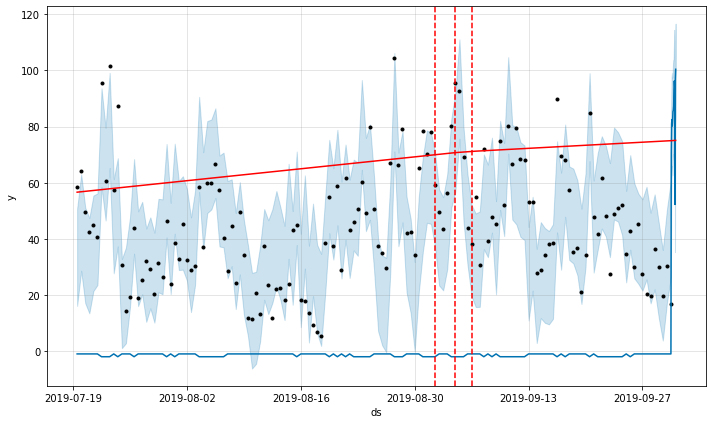

In [39]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)